In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches

%matplotlib inline
plt.rcParams.update({'font.size': 20})

root_directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/'
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'

In [2]:
directory = os.path.join(root_directory,'fly_5','func_0')
timestamps = bbb.load_timestamps(os.path.join(directory, 'imaging'))
fictrac_raw = bbb.load_fictrac(os.path.join(directory, 'fictrac'))


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 51.65 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.10 sec


In [3]:
t0 = time.time()
save_file = os.path.join(directory, 'pca', 'scores_(spatial).npy')
pca_spatial = np.load(save_file)
save_file = os.path.join(directory, 'pca', 'loadings_(temporal).npy')
pca_loadings = np.load(save_file)
print('Duration: {}'.format(time.time()-t0))

pca_spatial.shape = (pca_spatial.shape[0], -1)
pca_spatial.shape = (pca_spatial.shape[0], 77, 128, 49)

plt.imshow(pca_spatial[0,:,:,20])

Duration: 35.17844605445862


In [13]:
# can upsample brain to 100ms if needed

brain_x_original = timestamps[:,25]
expt_len = 1000*30*60 #in ms
new_rate = 100 # in ms
brain_x_new = np.arange(0,expt_len,new_rate)

brain_interp_temp = interp1d(brain_x_original, pca_loadings, kind='cubic', bounds_error = False, axis=0)
brain_interp = brain_interp_temp(brain_x_new)
print(brain_interp.shape)

In [27]:
num_pcs = 100
data = np.tensordot(brain_interp[:,:num_pcs], pca_spatial[:num_pcs,:,:,:],axes=1)
data = np.moveaxis(data,0,-1)

Duration: 1150.3057425022125


In [ ]:
num_pcs = 100
data = np.tensordot(pca_loadings[:,:num_pcs], pca_spatial[:num_pcs,:,:,:],axes=1)
data = np.moveaxis(data,0,-1)

print('Duration: {}'.format(time.time()-t0))

In [10]:
resolution = 100 #desired resolution in ms
expt_len = 1000*30*60
fps = 50 #of fictrac camera
behaviors = ['dRotLabY', 'dRotLabZ', 'heading']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    elif behavior == 'heading': short = 'heading'
    fictrac[short] = bbb.smooth_and_interp_fictrac(fictrac_raw,
                                                   fps,
                                                   resolution,
                                                   expt_len,
                                                   behavior,
                                                   timestamps=None,
                                                   smoothing=51)
    fictrac[short] = fictrac[short]/np.std(fictrac[short])
xnew = np.arange(0,expt_len,resolution)

In [34]:
# if playing with smoothing (probably not) #
resolution = 20 #desired resolution in ms
expt_len = 1000*30*60
fps = 50 #of fictrac camera
behaviors = ['dRotLabY', 'dRotLabZ']
fictrac = {}
smooths = [5,25,51,201]
for smooth in smooths:
    fictrac[smooth] = bbb.smooth_and_interp_fictrac(fictrac_raw,
                                                   fps,
                                                   resolution,
                                                   expt_len,
                                                   behavior='dRotLabZ',
                                                   smoothing=smooth)
xnew = np.arange(0,expt_len,resolution)

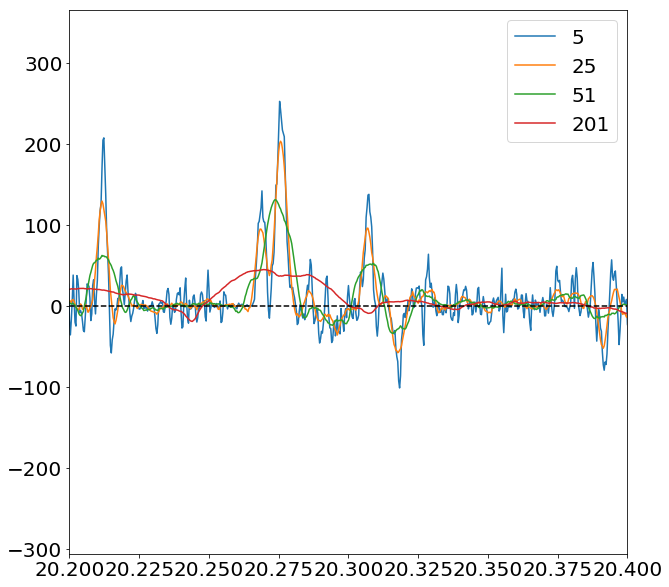

In [40]:
plt.figure(figsize=(10,10))
for smooth in smooths:
    plt.plot(xnew/1000/60, fictrac[smooth], label=smooth)
plt.xlim(20.2,20.4)
plt.legend()
plt.axhline(0,linestyle='--', color='k')

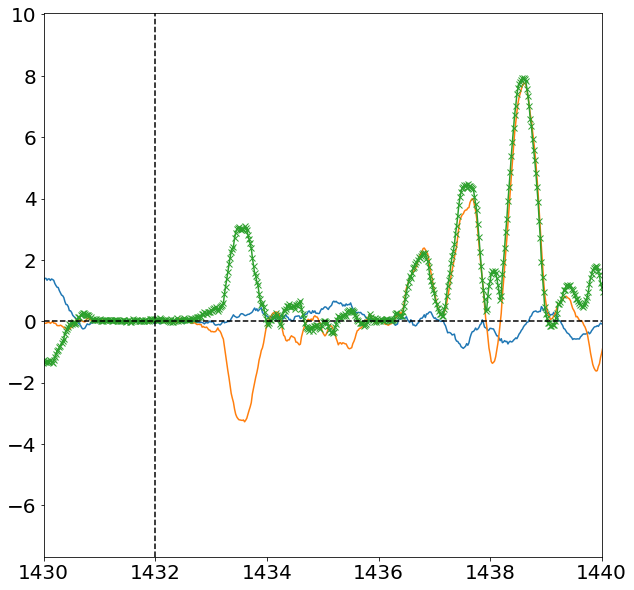

In [72]:
plt.figure(figsize=(10,10))
plt.plot(xnew/1000, fictrac['Y'])
plt.plot(xnew/1000, fictrac['Z'])
plt.plot(xnew/1000, np.abs(fictrac['Z'])-fictrac['Y'],marker='x')


plt.xlim(1430,1440)
plt.axhline(0,linestyle='--', color='k')
plt.axvline(1432,linestyle='--', color='k')

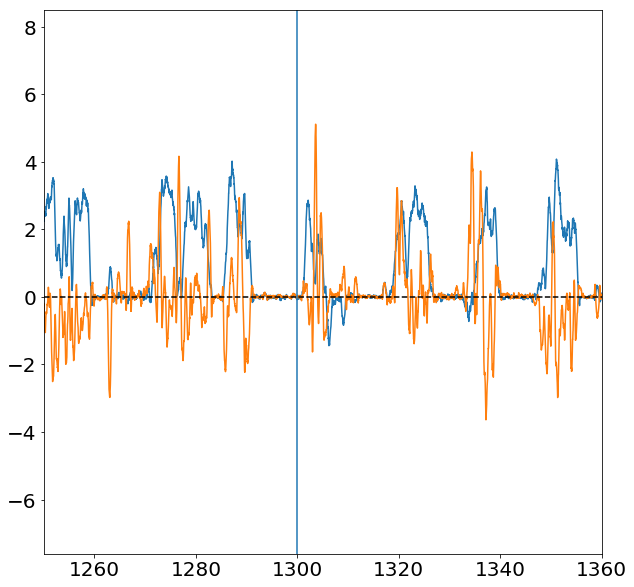

In [236]:
plt.figure(figsize=(10,10))
plt.plot(xnew/1000, fictrac['Y'])
plt.plot(xnew/1000, fictrac['Z'])
#plt.plot(xnew/1000, np.abs(fictrac['Z'])-fictrac['Y'])


plt.xlim(1250,1360)
plt.axvline(1300)
plt.axhline(0,linestyle='--', color='k')

In [7]:
def isInside(circle_x, circle_y, rad, x, y): 
    if ((x - circle_x) * (x - circle_x) + 
        (y - circle_y) * (y - circle_y) <= rad * rad): 
        return True; 
    else: 
        return False; 

In [ ]:
# We want to know at what time the fly BEGAN a TURN

In [11]:
VECTOR_LENGTH_MS = 500 #in ms
VECTOR_LENGTH_IDX = int(VECTOR_LENGTH_MS/resolution)
starts = []
stops = []

circle_thresh_inner = 0.5
circle_thresh_outer = 2

for i in range(len(fictrac['Y'])-VECTOR_LENGTH_IDX):
    START = i
    STOP = i + VECTOR_LENGTH_IDX
    
    # only select vectors that originate close enough to 0 (stopped fly)
    if isInside(circle_x=0, circle_y=0, rad=circle_thresh_inner, x=fictrac['Y'][START], y=fictrac['Z'][START]):
        pass
    else:
        continue
    
    # to prevent temporally overlapping bouts, require start to pass over circle boundary
    if not isInside(circle_x=0, circle_y=0, rad=circle_thresh_inner, x=fictrac['Y'][START+1], y=fictrac['Z'][START+1]):
        pass
    else:
        continue

    # is magnitude great enough?
    if not isInside(circle_x=0, circle_y=0, rad=circle_thresh_outer, x=fictrac['Y'][STOP], y=fictrac['Z'][STOP]):
        pass
    else:
        continue
        
    starts.append(START)
    stops.append(STOP)
    
print(len(starts))

88


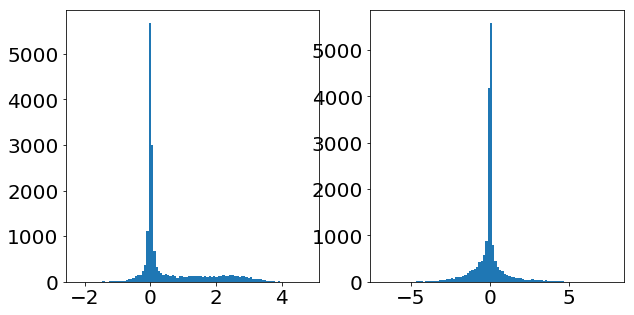

In [34]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(fictrac['Y'],bins=100);
plt.subplot(1,2,2)
plt.hist(fictrac['Z'],bins=100);

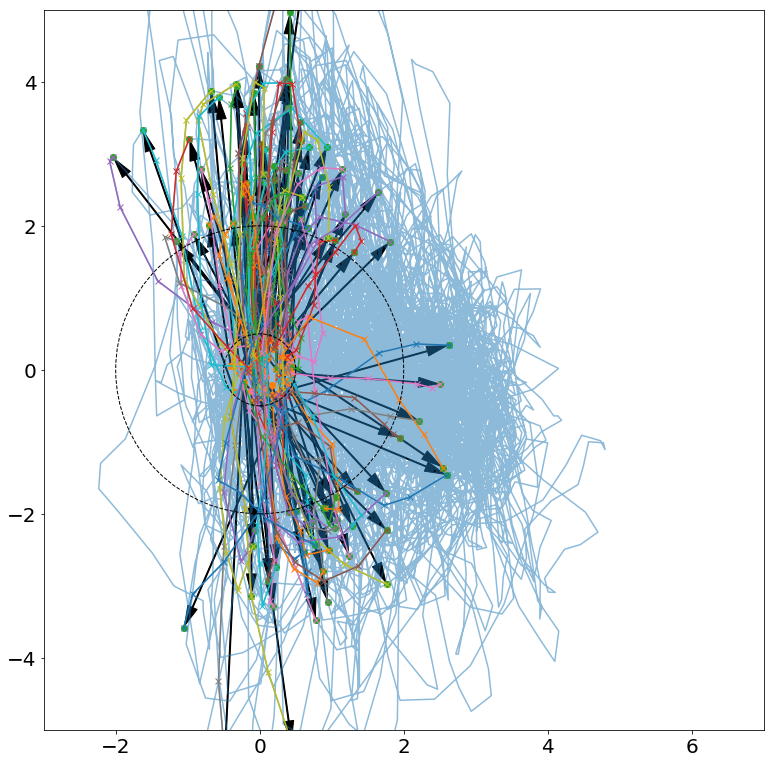

In [80]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,1,1])
x=fictrac['Y']
y=fictrac['Z']

ax.plot(x,y,alpha=.5)
#ax.plot(x[1432*50:1434*50],y[1432*50:1434*50],marker='x')
ax.plot(x[starts],y[starts],marker='o',linestyle='None')
ax.plot(x[stops],y[stops],marker='o',linestyle='None')

#many_secs_before = [i-50 for i in starts]
#ax.plot(x[many_secs_before],y[many_secs_before],marker='o',linestyle='None',zorder=3)

for start in starts:
    ax.plot(x[start:start+VECTOR_LENGTH_IDX+1],y[start:start+VECTOR_LENGTH_IDX+1],marker='x')
#plt.quiver(x[starts], y[starts], x[stops], y[stops], scale_units='xy', angles='xy', scale=1)

style="Simple,head_length=20,head_width=10,tail_width=1"
for i in range(len(starts)):
    arrow = mpatches.FancyArrowPatch((x[starts][i],y[starts][i]),
                                     (x[stops][i],y[stops][i]),
                                     arrowstyle=style,
                                     zorder=2,
                                     color='k',
                                     alpha=1)
    ax.add_patch(arrow)

circle_inner = plt.Circle((0, 0), circle_thresh_inner, color='k',linestyle='--',fill=False,zorder=2)
circle_outer = plt.Circle((0, 0), circle_thresh_outer, color='k',linestyle='--',fill=False,zorder=2)
ax.add_artist(circle_inner)
ax.add_artist(circle_outer)

ax.set_ylim(-5,5)
ax.set_xlim(-3,7)

timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, timestr + '.png')
plt.savefig(fname,dpi=300,bbox_inches='tight')

(-3, 7)

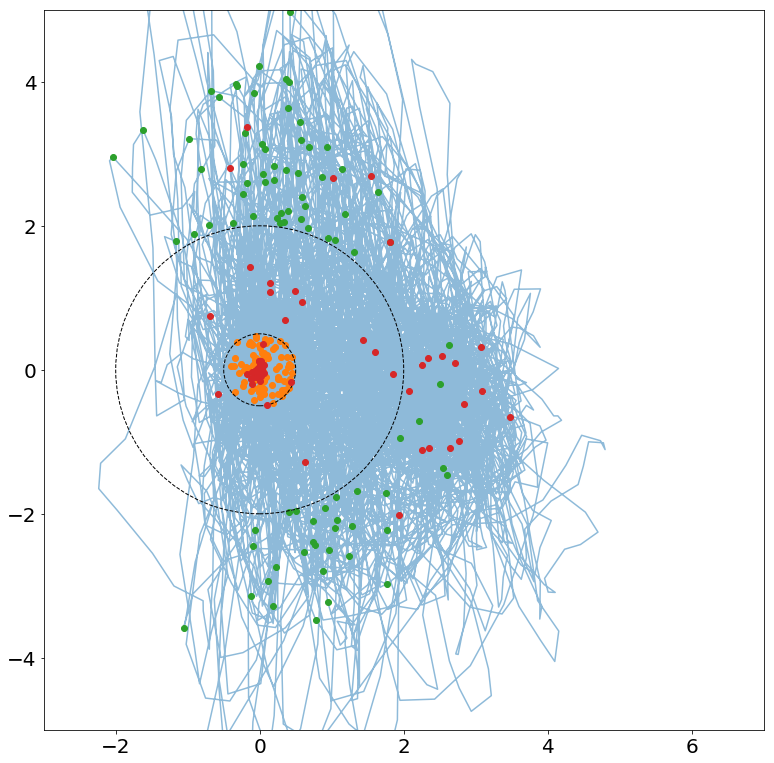

In [82]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,1,1])
x=fictrac['Y']
y=fictrac['Z']

ax.plot(x,y,alpha=.5)
#ax.plot(x[1432*50:1434*50],y[1432*50:1434*50],marker='x')
ax.plot(x[starts],y[starts],marker='o',linestyle='None')
ax.plot(x[stops],y[stops],marker='o',linestyle='None')

many_secs_before = [i-50 for i in starts]
ax.plot(x[many_secs_before],y[many_secs_before],marker='o',linestyle='None',zorder=3)

#for start in starts:
    #ax.plot(x[start:start+VECTOR_LENGTH_IDX+1],y[start:start+VECTOR_LENGTH_IDX+1],marker='x')
#plt.quiver(x[starts], y[starts], x[stops], y[stops], scale_units='xy', angles='xy', scale=1)

style="Simple,head_length=20,head_width=10,tail_width=1"
for i in range(len(starts)):
    arrow = mpatches.FancyArrowPatch((x[starts][i],y[starts][i]),
                                     (x[stops][i],y[stops][i]),
                                     arrowstyle=style,
                                     zorder=2,
                                     color='k',
                                     alpha=1)
    #ax.add_patch(arrow)

circle_inner = plt.Circle((0, 0), circle_thresh_inner, color='k',linestyle='--',fill=False,zorder=2)
circle_outer = plt.Circle((0, 0), circle_thresh_outer, color='k',linestyle='--',fill=False,zorder=2)
ax.add_artist(circle_inner)
ax.add_artist(circle_outer)

ax.set_ylim(-5,5)
ax.set_xlim(-3,7)

In [54]:
len(starts)

88

In [55]:
turn_start_pos = []
turn_start_neg = []
for i in range(len(starts)):
    if y[stops][i] > 0:
        turn_start_pos.append(starts[i])
    else:
        turn_start_neg.append(starts[i])

In [63]:
num_pcs = 100
#lets look at 5sec before to 5sec after. 10tp each sec, so 100 points
data_big = []
for i in range(-50,50):
    times = [x+i for x in turn_start_pos]
    data = np.tensordot(brain_interp[times,:num_pcs], pca_spatial[:num_pcs,:,:,:],axes=1)
    data = np.moveaxis(data,0,-1)
    data_big.append(data)

In [66]:
data_big=np.asarray(data_big)

In [67]:
data_big.shape

(100, 77, 128, 49, 54)

In [69]:
turn_brain = np.mean(data_big, axis=-1)
print(turn_brain.shape)

(100, 77, 128, 49)


In [73]:
turn_brain_2 = np.moveaxis(turn_brain, 0,-1)
print(turn_brain_2.shape)

(77, 128, 49, 100)


In [74]:
values_to_save = ants.from_numpy(turn_brain_2)
file = os.path.join(directory,'20200521_bout_analysis','turn_trigger.nii')
ants.image_write(values_to_save,file)

In [501]:
# create bounding boxes
forward_min = 1
forward_max = 5
forward_width = 1

rotation_min = 1
rotation_max = 6
rotation_forward_bias = 2
rotation_reverse_bias = 0

stop_r = 0.2

In [502]:
f1 = np.where(fictrac['Y']>forward_min)[0]
f2 = np.where(np.abs(fictrac['Z'])<forward_width)[0]
f3 = np.where(fictrac['Y']<forward_max)[0]
forward_times = [i for i in f1 if i in f2 and i in f3]

r1 = np.where(fictrac['Z']>rotation_min)[0]
r2 = np.where(fictrac['Z']<rotation_max)[0]
r3 = np.where(fictrac['Y']>rotation_reverse_bias)[0]
r4 = np.where(fictrac['Y']<rotation_forward_bias)[0]
rotation_pos_times = [i for i in r1 if i in r2 and i in r3 and i in r4]

r1 = np.where(fictrac['Z']<-rotation_min)[0]
r2 = np.where(fictrac['Z']>-rotation_max)[0]
r3 = np.where(fictrac['Y']>rotation_reverse_bias)[0]
r4 = np.where(fictrac['Y']<rotation_forward_bias)[0]
rotation_neg_times = [i for i in r1 if i in r2 and i in r3 and i in r4]

rotation_times = rotation_pos_times + rotation_neg_times

stop_times = np.where(fictrac['Y']**2 + fictrac['Z']**2 < stop_r**2)[0]

print(len(forward_times), len(rotation_pos_times), len(rotation_neg_times), len(stop_times), len(rotation_times))

645 234 225 2447 459


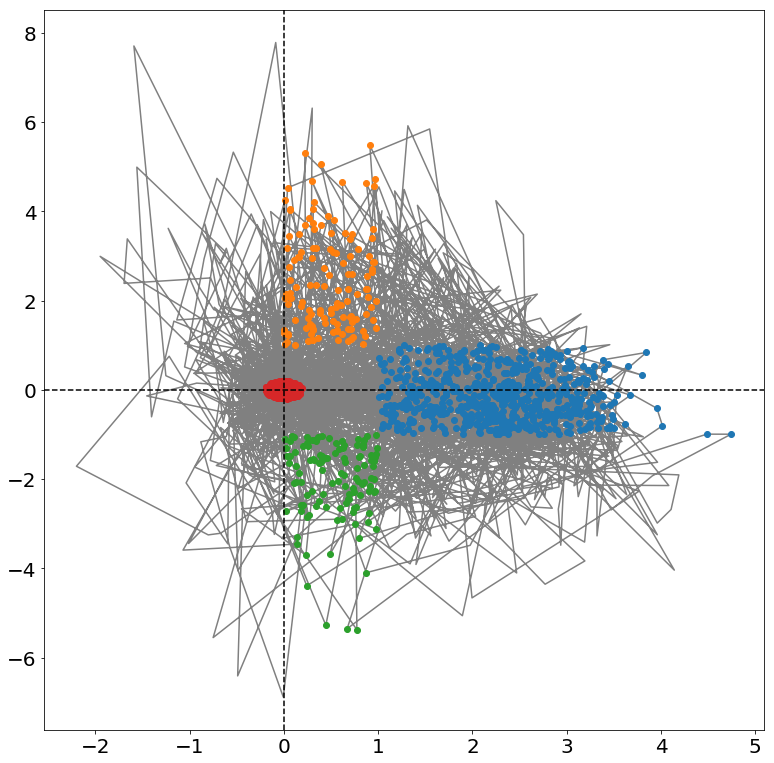

In [491]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,1,1])
x=fictrac['Y']
y=fictrac['Z']
ax.plot(x,y,color='grey')
ax.plot(x[forward_times],y[forward_times],marker='o',linestyle='None')
ax.plot(x[rotation_pos_times],y[rotation_pos_times],marker='o',linestyle='None')
ax.plot(x[rotation_neg_times],y[rotation_neg_times],marker='o',linestyle='None')
ax.plot(x[stop_times],y[stop_times],marker='o',linestyle='None')


ax.axvline(0, linestyle='--', color='k')
ax.axhline(0, linestyle='--', color='k')

In [503]:
num_pcs = 100

forward_map = np.tensordot(pca_loadings[forward_times,:num_pcs], pca_spatial[:num_pcs,:,:,:],axes=1)
forward_map = np.mean(forward_map,axis=0)

stop_map = np.tensordot(pca_loadings[stop_times,:num_pcs], pca_spatial[:num_pcs,:,:,:],axes=1)
stop_map = np.mean(stop_map,axis=0)

rotation_pos_map = np.tensordot(pca_loadings[rotation_pos_times,:num_pcs], pca_spatial[:num_pcs,:,:,:],axes=1)
rotation_pos_map = np.mean(rotation_pos_map,axis=0)

rotation_neg_map = np.tensordot(pca_loadings[rotation_neg_times,:num_pcs], pca_spatial[:num_pcs,:,:,:],axes=1)
rotation_neg_map = np.mean(rotation_neg_map,axis=0)

rotation_map = np.tensordot(pca_loadings[rotation_times,:num_pcs], pca_spatial[:num_pcs,:,:,:],axes=1)
rotation_map = np.mean(rotation_map,axis=0)

In [127]:
avg_map = np.tensordot(pca_loadings[::10,:num_pcs], pca_spatial[:num_pcs,:,:,:],axes=1)
avg_map = np.mean(avg_map,axis=0)

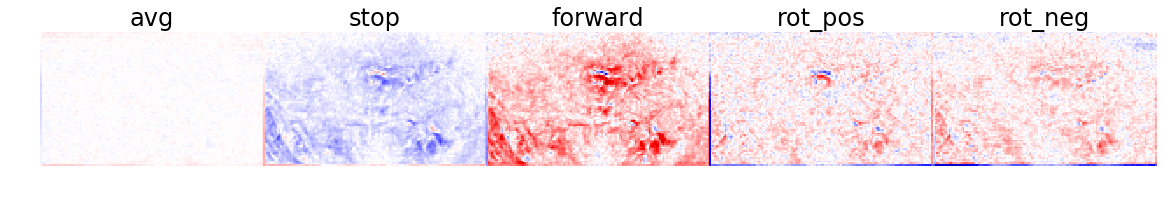

In [494]:
fig = plt.figure(figsize=(20,10))

vmin=-.6
vmax=.6
z=21

ax = plt.subplot(1,5,1)
ax.imshow(avg_map[:,:,z],vmin=vmin, vmax=vmax, cmap='seismic')
ax.axis('off')
ax.set_title('avg')

ax = plt.subplot(1,5,2)
ax.imshow(stop_map[:,:,z],vmin=vmin, vmax=vmax, cmap='seismic')
ax.axis('off')
ax.set_title('stop')


ax = plt.subplot(1,5,3)
ax.imshow(forward_map[:,:,z],vmin=vmin, vmax=vmax, cmap='seismic')
ax.axis('off')
ax.set_title('forward')


ax = plt.subplot(1,5,4)
ax.imshow(rotation_pos_map[:,:,z],vmin=vmin, vmax=vmax, cmap='seismic')
ax.axis('off')
ax.set_title('rot_pos')


ax = plt.subplot(1,5,5)
ax.imshow(rotation_neg_map[:,:,z],vmin=vmin, vmax=vmax, cmap='seismic')
ax.axis('off')
ax.set_title('rot_neg')


plt.subplots_adjust(wspace=0, hspace=0)
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, timestr + '.png')
plt.savefig(fname,dpi=300,bbox_inches='tight')

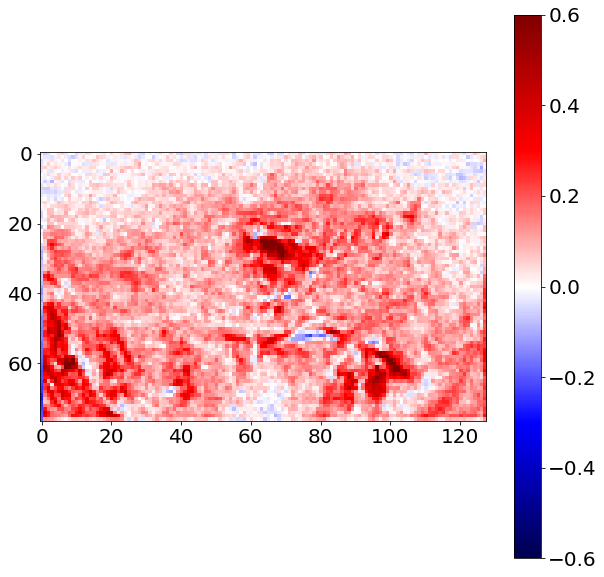

In [167]:
fig = plt.figure(figsize=(10,10))
z=20
plt.imshow(forward_map[:,:,z]-stop_map[:,:,z],vmin=-.6, vmax=.6, cmap='seismic')
plt.colorbar()

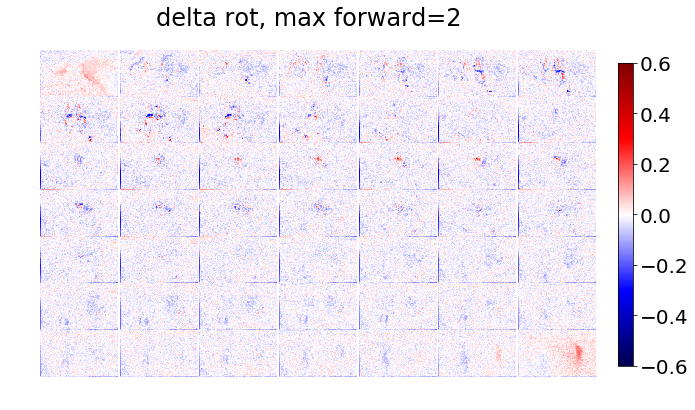

In [504]:
fig = plt.figure(figsize=(10,77/128*10))
z=2
for z in range(49):
    ax = plt.subplot(7,7,z+1)
    ax.axis('off')
    im = ax.imshow(rotation_pos_map[:,:,z]-rotation_neg_map[:,:,z],vmin=-.6, vmax=.6, cmap='seismic')
plt.subplots_adjust(wspace=0, hspace=0)
cbar_ax = fig.add_axes([.93, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.suptitle('delta rot, max forward=2')
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, timestr + '.png')
plt.savefig(fname,dpi=300,bbox_inches='tight')

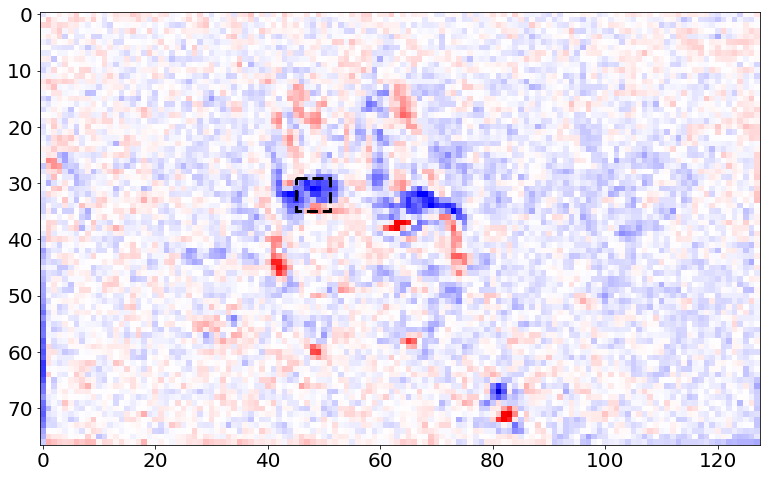

In [460]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,1,1])
ax.imshow(rotation_pos_map[:,:,7]-rotation_neg_map[:,:,7],vmin=-.6, vmax=.6, cmap='seismic')

# circle = plt.Circle((47, 33), 3, color='k',linestyle='--',fill=False,zorder=2)
# ax.add_artist(circle)

rect = plt.Rectangle((45, 29), 6, 6, color='k',linestyle='--',fill=False,zorder=2,linewidth=3)
ax.add_artist(rect)
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, timestr + '.png')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [447]:
np.ndarray.flatten(rotation_pos_map[29:35, 45:51, 7])

array([ 0.03453696,  0.00037265, -0.00892581,  0.06971496, -0.01919637,
        0.01604187,  0.02682319,  0.02064265, -0.02061266, -0.03118995,
       -0.05127191, -0.06176742,  0.05422999,  0.14292984,  0.07584649,
       -0.01721385, -0.03546338, -0.00490055,  0.01122303,  0.16607291,
        0.14623481, -0.0049959 ,  0.01681605,  0.05625007,  0.02163553,
        0.10956941,  0.1082077 ,  0.06085045, -0.03882516, -0.0235798 ,
        0.06677262,  0.1002192 ,  0.05337649,  0.14177321,  0.12854639,
        0.09565638])

In [446]:
rotation_pos_map.shape

(77, 128, 49)

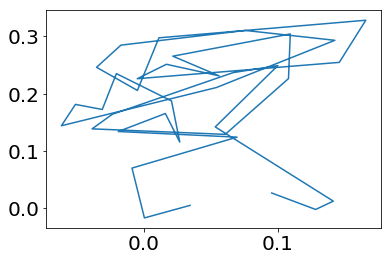

In [448]:
x=45
y=29
width=6
z=7
plt.plot(np.ndarray.flatten(rotation_pos_map[y:y+width, x:x+width, z]),
         np.ndarray.flatten(rotation_neg_map[y:y+width, x:x+width, z]))

In [371]:
forward_flat = np.ndarray.flatten(forward_map)
rotation_flat = np.ndarray.flatten(rotation_map)

In [373]:
rotation_pos_flat = np.ndarray.flatten(rotation_pos_map)
rotation_neg_flat = np.ndarray.flatten(rotation_neg_map)

In [308]:
sum(diff_map)

317

In [400]:
diff_map = []
for i in range(len(forward_flat)):
    if isInside(circle_x=-.2, circle_y=.15, rad=0.3, x=rotation_pos_flat[i], y=rotation_neg_flat[i]):
        diff_map.append(1)
    else:
        diff_map.append(0)
        
diff_map = np.reshape(diff_map, forward_map.shape)

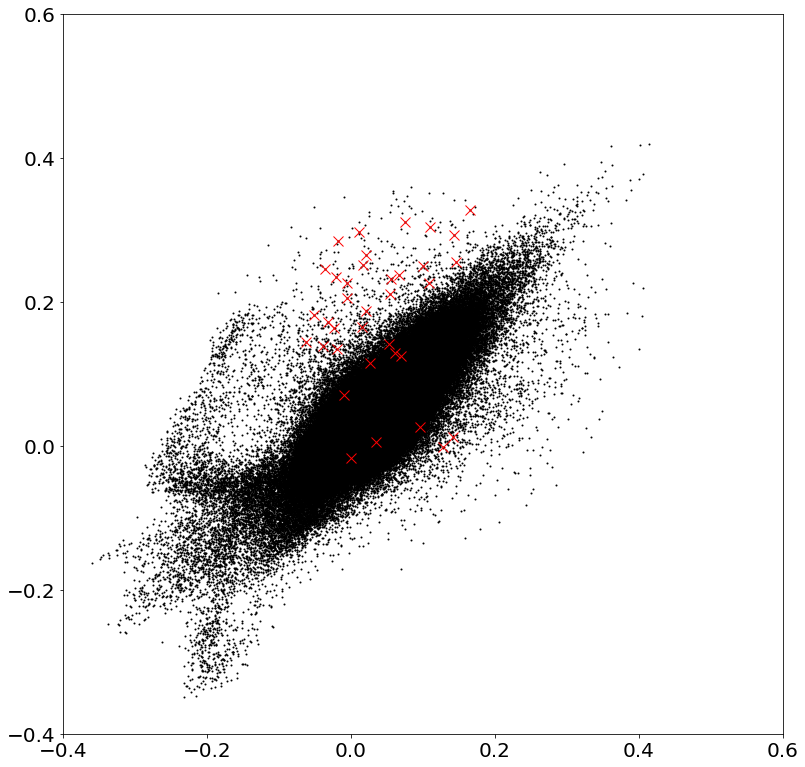

In [461]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,1,1])
ax.plot(rotation_pos_flat,rotation_neg_flat,linestyle='None',marker='o',markersize=1,color='k')

circle = plt.Circle((-.2, -.05), .06, color='r',linestyle='--',fill=False,zorder=2)
#ax.add_artist(circle)

circle = plt.Circle((-.2, -.2), .12, color='blue',linestyle='--',fill=False,zorder=2)
#ax.add_artist(circle)

circle = plt.Circle((-.2, .15), 0.3, color='cyan',linestyle='--',fill=False,zorder=2)
#ax.add_artist(circle)

plt.plot(np.ndarray.flatten(rotation_pos_map[y:y+width, x:x+width, z]),
         np.ndarray.flatten(rotation_neg_map[y:y+width, x:x+width, z]),
         linestyle='None',
         marker='x',
         zorder=2,
         markersize=10,
         color='r')

ax.set_ylim(-.4,.6)
ax.set_xlim(-.4,.6)

timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, timestr + '.png')
plt.savefig(fname,dpi=300,bbox_inches='tight')

In [467]:
def best_fit_slope_and_intercept(xs,ys):
    m = (((np.mean(xs)*np.mean(ys)) - np.mean(xs*ys)) /
         ((np.mean(xs)*np.mean(xs)) - np.mean(xs*xs)))
    
    b = np.mean(ys) - m*np.mean(xs)
    
    return m, b

m, b = best_fit_slope_and_intercept(forward_flat,rotation_flat)

In [469]:
b

0.0018548954011683681

In [470]:
regression_line = [(m*x)+b for x in [.1,.2]]

In [482]:
predictions = [(m*x)+b for x in forward_flat]
residuals = predictions-rotation_flat

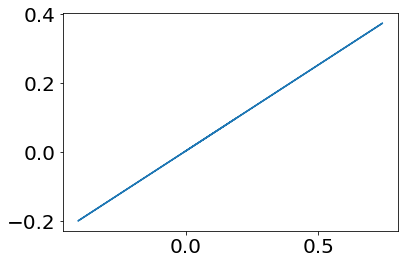

In [480]:
plt.plot(forward_flat,predictions)

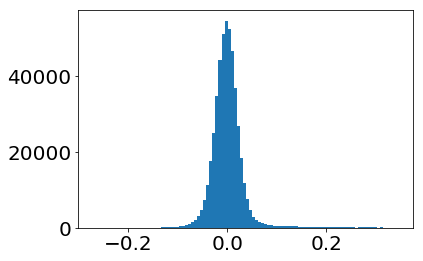

In [483]:
plt.hist(residuals,bins=100);

In [484]:
residuals_map = np.reshape(residuals, forward_map.shape)

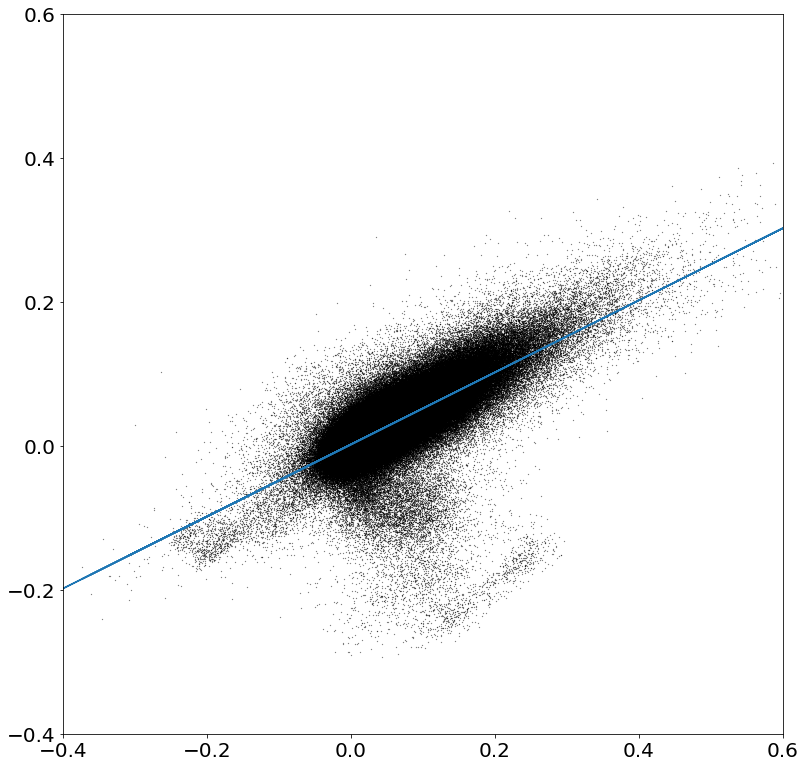

In [488]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,1,1])
ax.plot(forward_flat,rotation_flat,linestyle='None',marker='o',markersize=.2,color='k')
xs=[-.2,.4]
#ax.plot(xs, [(m*x)+b for x in xs])
ax.plot(forward_flat,predictions)
#circle = plt.Circle((0.14, -.16), .12, color='r',linestyle='--',fill=False,zorder=2)
#ax.add_artist(circle)

#circle = plt.Circle((-.15, -.15), .12, color='blue',linestyle='--',fill=False,zorder=2)
#ax.add_artist(circle)

ax.set_ylim(-.4,.6)
ax.set_xlim(-.4,.6)

timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, timestr + '.png')
plt.savefig(fname,dpi=300,bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(20,10))

vmin=-.6
vmax=.6
z=21

ax = plt.subplot(1,5,1)
ax.imshow(avg_map[:,:,z],vmin=vmin, vmax=vmax, cmap='seismic')
ax.axis('off')
ax.set_title('avg')

ax = plt.subplot(1,5,2)
ax.imshow(stop_map[:,:,z],vmin=vmin, vmax=vmax, cmap='seismic')
ax.axis('off')
ax.set_title('stop')


ax = plt.subplot(1,5,3)
ax.imshow(forward_map[:,:,z],vmin=vmin, vmax=vmax, cmap='seismic')
ax.axis('off')
ax.set_title('forward')


ax = plt.subplot(1,5,4)
ax.imshow(rotation_pos_map[:,:,z],vmin=vmin, vmax=vmax, cmap='seismic')
ax.axis('off')
ax.set_title('rot_pos')


ax = plt.subplot(1,5,5)
ax.imshow(rotation_neg_map[:,:,z],vmin=vmin, vmax=vmax, cmap='seismic')
ax.axis('off')
ax.set_title('rot_neg')


plt.subplots_adjust(wspace=0, hspace=0)

timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, timestr + '.png')
plt.savefig(fname,dpi=300,bbox_inches='tight')

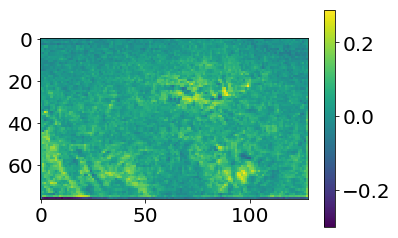

In [117]:
plt.imshow(rotation_neg_map[:,:,22])
plt.colorbar()

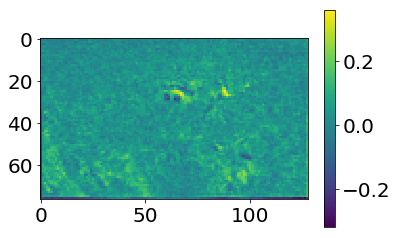

In [118]:
plt.imshow(rotation_pos_map[:,:,22])
plt.colorbar()

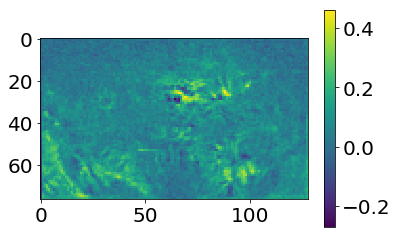

In [119]:
plt.imshow(forward_map[:,:,22])
plt.colorbar()

In [70]:
data.shape

(128, 77, 49)

In [63]:
pca_loadings.shape

(4731, 4731)

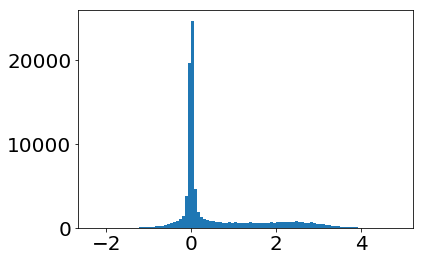

In [15]:
plt.hist(fictrac['Y'],bins=100);

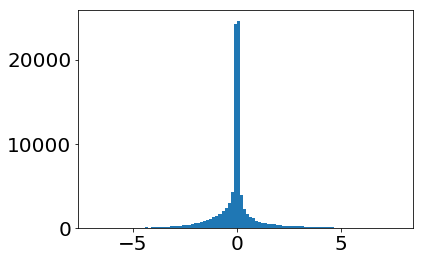

In [16]:
plt.hist(fictrac['Z'],bins=100);

In [ ]:
# simply want lines that go straight left/right, or straight up/down. Don't even need them to loop back
# Look for line segments of length x with an average vector enough magnitude, and correct direction

In [104]:
###### CURRENT BEST METHOD ######

B_THRESHOLD = np.std(fictrac['Y'])/8
ALIVE_TIME = 200 # in ms
DEAD_TIME = 1000 # in ms

behavior = 'quiescent'
up_streak = 0
down_streak = 0
BOUTS = []
ALIVE_TIME = int(ALIVE_TIME/resolution) # now in units of single timesteps
DEAD_TIME = int(DEAD_TIME/resolution)

for i in range(len(fictrac['Y'])):
    # If high behavior, reset down_streak, and add 1 to up_streak
    if fictrac['Y'][i] > B_THRESHOLD:
        down_streak = 0
        up_streak += 1
    else:
        up_streak = 0
        down_streak += 1
        
    if behavior == 'quiescent':
        if up_streak >= ALIVE_TIME:
            behavior = 'moving'
            BOUTS.append({'start': i-ALIVE_TIME})
    elif behavior == 'moving':
        if down_streak >= DEAD_TIME:
            behavior = 'quiescent'
            BOUTS[-1]['end'] = i-DEAD_TIME
print('Found {} bouts'.format(len(BOUTS)))

# output bouts are in units of timesteps aka indicies into fictrac data

Found 126 bouts


Text(0.5, 0, 'sec')

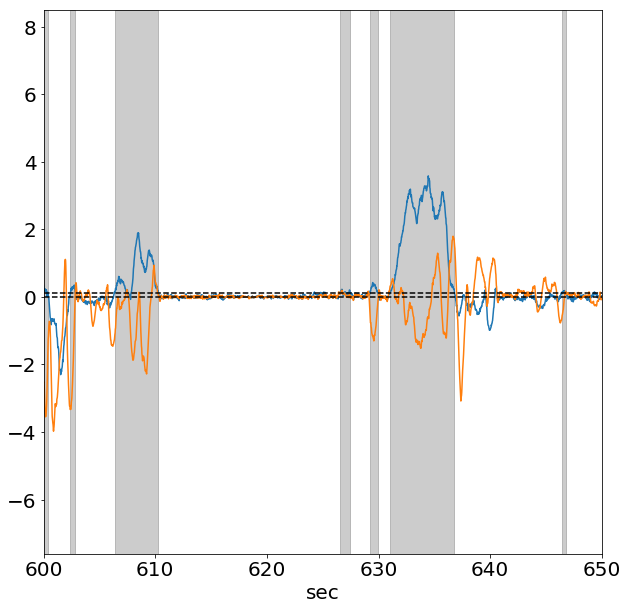

In [109]:
plt.figure(figsize=(10,10))

plt.plot(xnew/1000, fictrac['Y'])
plt.plot(xnew/1000, fictrac['Z'])
#plt.plot(xnew/1000,PB_signal_highres/10)

for bout in BOUTS:
    try:
        plt.axvspan(bout['start']/50, bout['end']/50, alpha=0.2, color='k')
        #plt.axvline(bout['start']/50,color='r',linestyle='--')
    except:
        pass
    
plt.axhline(0,color='k',linestyle='--')
plt.axhline(B_THRESHOLD,color='k',linestyle='--')
plt.xlim(600,650)
plt.xlabel('sec')
#plt.xlim(808,1000)

# heading?

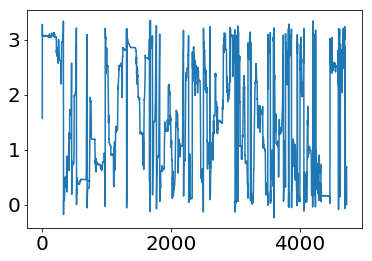

In [508]:
plt.plot(fictrac['heading'])

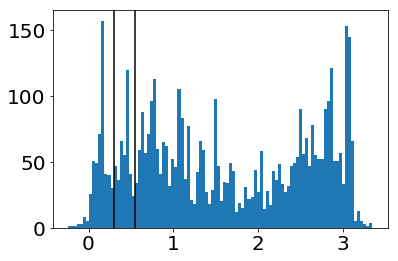

In [528]:
plt.hist(fictrac['heading'],bins=100);
plt.axvline(.3,color='k')
plt.axvline(.55,color='k')

In [529]:
f1 = np.where(fictrac['heading']>.3)[0]
f2 = np.where(fictrac['heading']<.55)[0]
heading_times = [i for i in f1 if i in f2]
len(heading_times)

369

In [511]:
heading_high_times = np.where(fictrac['heading']>2)[0]
heading_low_times = np.where(fictrac['heading']<=2)[0]

In [512]:
num_pcs = 100

heading_high_map = np.tensordot(pca_loadings[heading_high_times,:num_pcs], pca_spatial[:num_pcs,:,:,:],axes=1)
heading_high_map = np.mean(heading_high_map,axis=0)

heading_low_map = np.tensordot(pca_loadings[heading_low_times,:num_pcs], pca_spatial[:num_pcs,:,:,:],axes=1)
heading_low_map = np.mean(heading_low_map,axis=0)

In [530]:
heading_map = np.tensordot(pca_loadings[heading_times,:num_pcs], pca_spatial[:num_pcs,:,:,:],axes=1)
heading_map = np.mean(heading_map,axis=0)

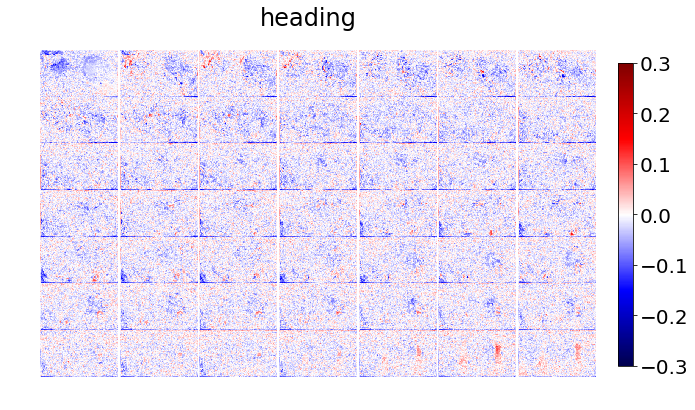

In [531]:
fig = plt.figure(figsize=(10,77/128*10))
z=2
for z in range(49):
    ax = plt.subplot(7,7,z+1)
    ax.axis('off')
    im = ax.imshow(heading_map[:,:,z],vmin=-.3, vmax=.3, cmap='seismic')
plt.subplots_adjust(wspace=0, hspace=0)
cbar_ax = fig.add_axes([.93, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.suptitle('heading')
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, timestr + '.png')
plt.savefig(fname,dpi=300,bbox_inches='tight')

# Velocity increments?

In [ ]:
# first, get maps for each velocity window
# second, for each voxel 

In [ ]:
# create bounding boxes
forward_min = 1
forward_max = 5
forward_width = 1



In [534]:
f1 = np.where(fictrac['Y']>.5)[0]
f2 = np.where(np.abs(fictrac['Z'])<forward_width)[0]
f3 = np.where(fictrac['Y']<1.5)[0]
forward_times_1 = [i for i in f1 if i in f2 and i in f3]

f1 = np.where(fictrac['Y']>1.5)[0]
f2 = np.where(np.abs(fictrac['Z'])<forward_width)[0]
f3 = np.where(fictrac['Y']<2.5)[0]
forward_times_2 = [i for i in f1 if i in f2 and i in f3]

f1 = np.where(fictrac['Y']>2.5)[0]
f2 = np.where(np.abs(fictrac['Z'])<forward_width)[0]
f3 = np.where(fictrac['Y']<3.5)[0]
forward_times_3 = [i for i in f1 if i in f2 and i in f3]

f1 = np.where(fictrac['Y']>3.5)[0]
f2 = np.where(np.abs(fictrac['Z'])<forward_width)[0]
f3 = np.where(fictrac['Y']<4.5)[0]
forward_times_4 = [i for i in f1 if i in f2 and i in f3]

print(len(forward_times_1),
      len(forward_times_2),
      len(forward_times_3),
      len(forward_times_4))

229 310 227 11


In [532]:
(4-.5)/4

0.875

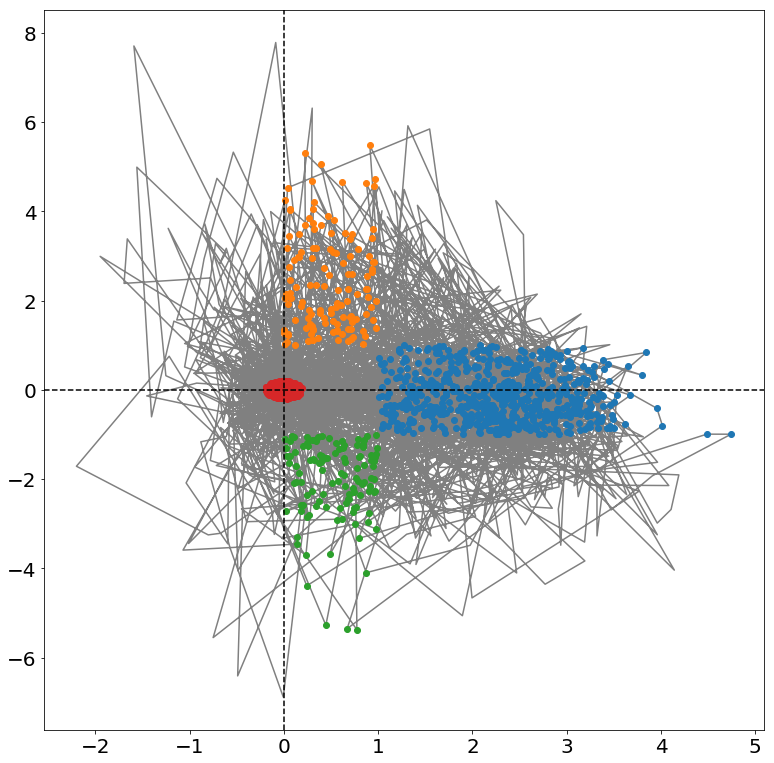

In [491]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,1,1])
x=fictrac['Y']
y=fictrac['Z']
ax.plot(x,y,color='grey')
ax.plot(x[forward_times],y[forward_times],marker='o',linestyle='None')
ax.plot(x[rotation_pos_times],y[rotation_pos_times],marker='o',linestyle='None')
ax.plot(x[rotation_neg_times],y[rotation_neg_times],marker='o',linestyle='None')
ax.plot(x[stop_times],y[stop_times],marker='o',linestyle='None')


ax.axvline(0, linestyle='--', color='k')
ax.axhline(0, linestyle='--', color='k')